# Установка и загрузка библиотек

In [1]:
!pip install pytesseract

In [2]:
!pip install easyocr

In [3]:
!pip install natasha==1.4.0

In [4]:
from PIL import Image
import pytesseract
import os
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import re
import easyocr

from natasha import (
    Segmenter,
    MorphVocab,  
    PER,
    NamesExtractor,
    NewsNERTagger,   
    NewsEmbedding,
    Doc
)
 
import nltk
import pymorphy2

# Работа с изображениями

In [5]:
path = "_DataForOCR/DataForOCR_/"

In [6]:
os.listdir(path)

['0.jpeg',
 '1.jpeg',
 '2.jpeg',
 '3.jpeg',
 '4.png',
 '5.jpeg',
 '6.jpeg',
 '7.jpeg',
 '8.jpeg',
 '9.jpeg']

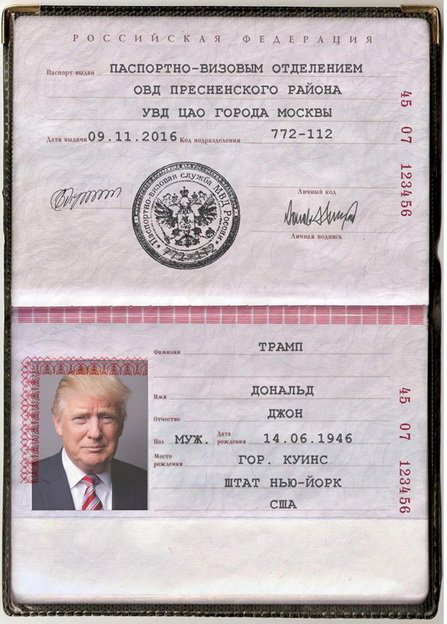

In [7]:
image  = path+os.listdir(path)[0]
image = Image.open(image).convert('RGB')
image

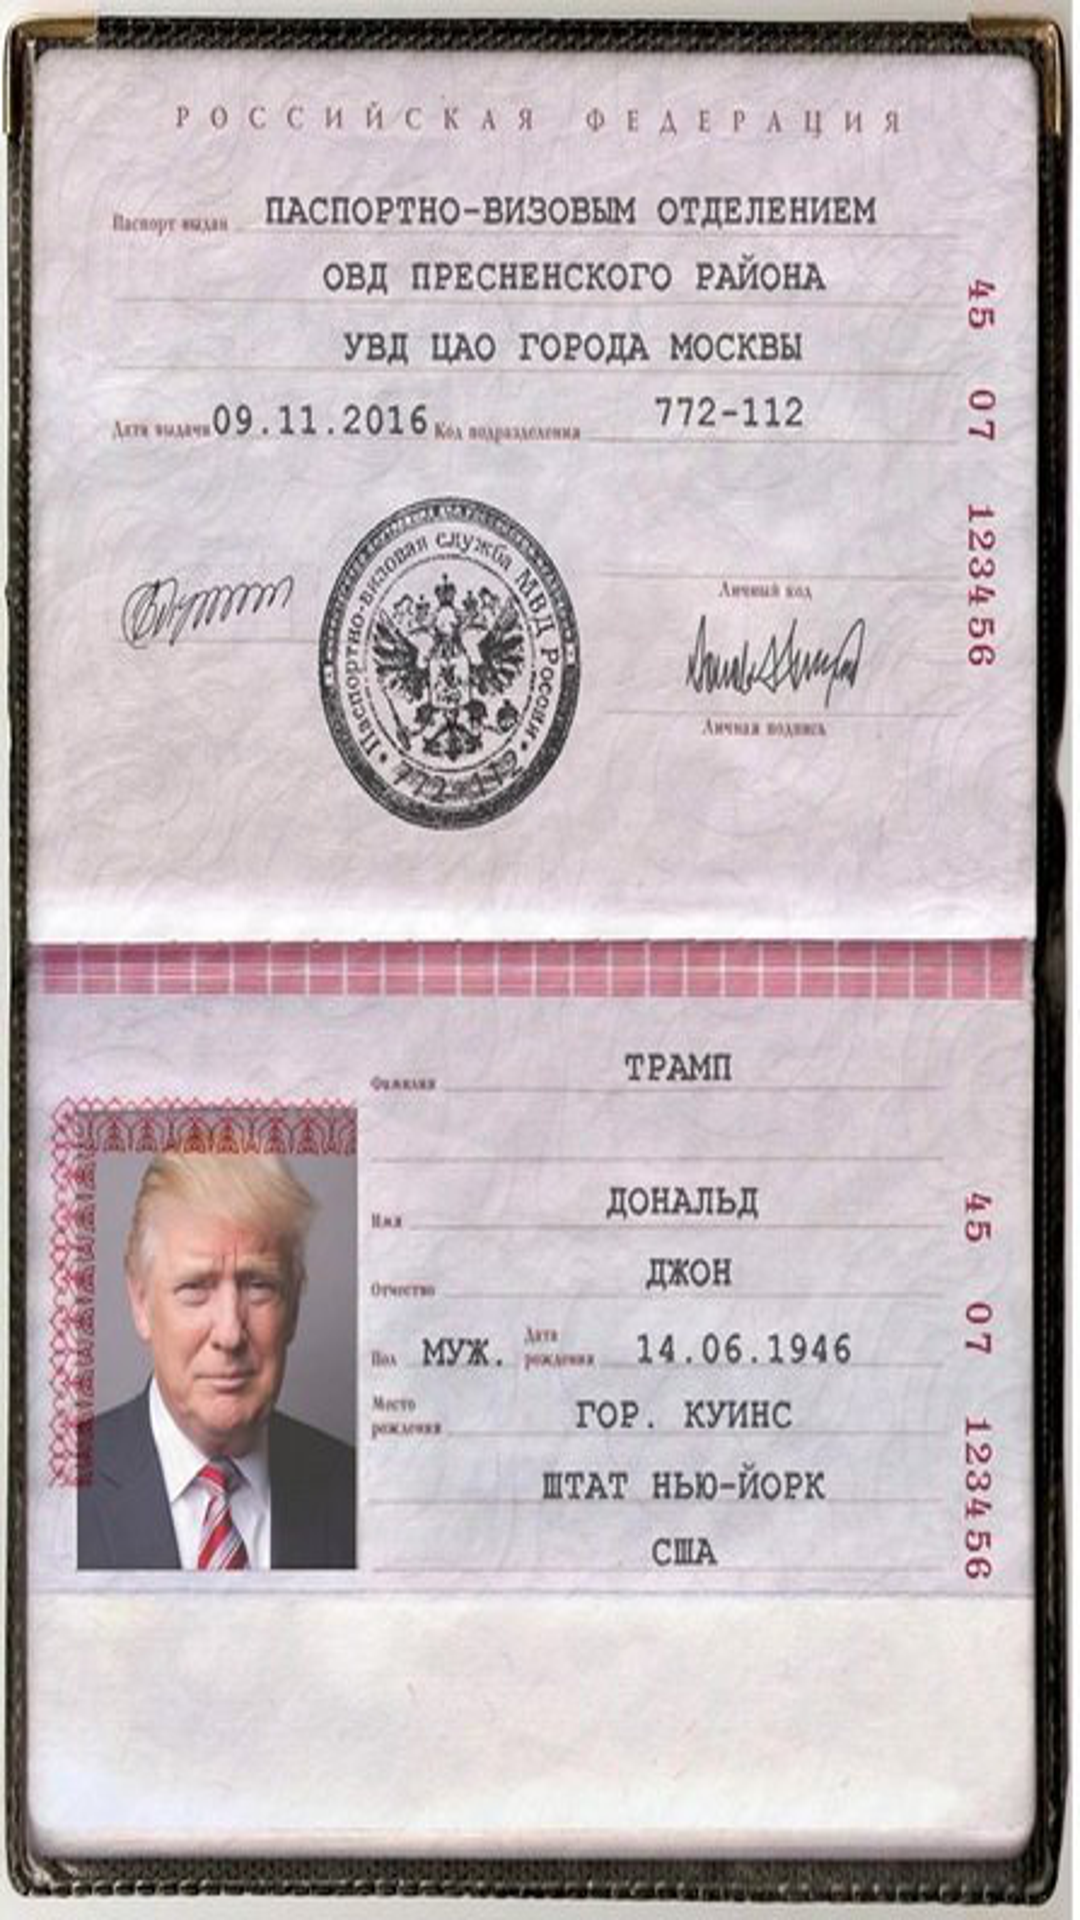

In [8]:
newsize = (1080, 1920)
im1 = image.resize(newsize)
# Shows the image in image viewer
im1

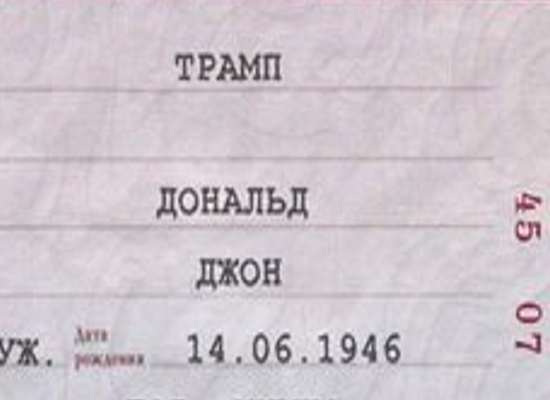

In [9]:
area = (450, 1000, 1000, 1400)
im1_crop = im1.crop(area)
im1_crop

# Pytesseract

In [10]:
im1_crop = np.asarray(im1_crop)
im1 = np.asarray(im1)

In [11]:
pytesseract.pytesseract.tesseract_cmd = "C:/Users/user/Downloads/tessssss/tesseract.exe"

In [12]:
text_crop = pytesseract.image_to_string(im1_crop, lang ="rus")
text_crop

'№"\n\nУЖ. мкм»\n\nТРАМП\n\nДОНАЛЬД\nДжон\n14.06.1946\n\nВл\n\n20\n'

In [13]:
text_full = pytesseract.image_to_string(im1, lang ="rus")
text_full

'РОССИЙСКАЯ ФЕДЕРАЦИЯ\n\nПАСПОРТНО-ВИЗОВЫМ ОТДЕЛЕНИЕМ\nОВД ПРЕСНЕНСКОГО РАЙОНА\nУВД ЦАО ГОРОДА МОСКВЫ\n\nтиб 06, дыры 1127112\n\nПасторе жа\n\nз*\n\n20\n\n—\n№\n[\n=\nбл\n©\n\nЗа к а 8 БЕ ВА О ЕЕ 5 5 Е ЕЕ ББ КЕЙ И БЕ 55 НЕ 5 Е\n\nТРАМП\n\nДОНАЛЬД\nДЖОН\n„= 14.06.1946\nГОР. КУИНС\nШТАТ НЬЮ-ЙОРК\nСША\n\nЭСИЕЗТ\n\n'

# Easyocr

In [14]:
reader = easyocr.Reader(['ru'])

In [15]:
text_crop = reader.readtext(im1_crop, detail=0)
print(text_crop)

['ТРАМП', 'ДОНАЛЪД', '0', 'ДЖОН', '0', 'уж .', "'", '14.06.1946', 'ш', '1|']


In [16]:
text_full = reader.readtext(im1, detail=0)
print(text_full)

['₽ 0 € € И Й € к ; Я', 'ф Т А [ ₽ АьИ %', 'ати,', 'ПАСПОРТНО-ВИЗОВЫМ ОТДЕЛЕНИЕМ', 'ОВД ПРЕСНЕНСКОГО  РАЙОНА', '0', 'УВД ЦАО ГОРОДА МОСКВЫ', 'Ачм', '09', '11.2016', "'0", '772-112', '9', '(', ';', '{{', 'ТРАМП', '1', 'ДОНАЛЬД', '0', '0', 'ДЖОН', 'Дм"', 'Муж .', 'А# ;', '14.06.1946', '9', 'Миур', 'ГОР', 'КУИНС', 'ШТАТ НЬЮ-ЙОРК', ';', 'США', 'ш']


### Результат easyocr лучше чем результат pytesseract, поэтому остаемся работать с easyocr

In [17]:
word_clean = re.compile(r'[A-Яa-яA-Za-zёЁ]+') 

def clean_text(txt):
    words=''
    txt = txt.lower()
    txt = re.sub(r'\d+ из \d+', '', txt)
    for word in re.findall(word_clean,txt):
        words = words + ' ' + word
    return words.strip()

In [19]:
text_full_s = ""
for i in range(len(text_full)):
    text_full_s+=text_full[i]
    text_full_s+=" "
text_full_s

'₽ 0 € € И Й € к ; Я ф Т А [ ₽ АьИ % ати, ПАСПОРТНО-ВИЗОВЫМ ОТДЕЛЕНИЕМ ОВД ПРЕСНЕНСКОГО  РАЙОНА 0 УВД ЦАО ГОРОДА МОСКВЫ Ачм 09 11.2016 \'0 772-112 9 ( ; {{ ТРАМП 1 ДОНАЛЬД 0 0 ДЖОН Дм" Муж . А# ; 14.06.1946 9 Миур ГОР КУИНС ШТАТ НЬЮ-ЙОРК ; США ш '

In [21]:
text_full = clean_text(text_full_s)
text_full

'и й к я ф т а [ аьи ати паспортно визовым отделением овд пресненского района увд цао города москвы ачм {{ трамп дональд джон дм муж а миур гор куинс штат нью йорк сша ш'

# Чистка текста и вывод ФИО

In [22]:
text = ''
for i in range(len(text_crop)):
    text+=text_crop[i]
    text+=" "
text = text.replace("\n", " ")
text = clean_text(text)
text = text.split()
new_text = ""
for i in range(len(text)):
    if len(text[i])>3:
        new_text+=text[i]
        new_text+=" "
text = new_text
text = text.split()
print(text[0], text[1], text[2])

трамп доналъд джон


# Попробуем поискать имена через nltk и natasha

In [23]:
#nltk
prob_thresh = 0.6

morph = pymorphy2.MorphAnalyzer()

text = text_full
print(text)
for word in nltk.word_tokenize(text):
    for p in morph.parse(word):
        if 'Name' in p.tag and p.score >= prob_thresh:
            ans = word
            print('{:<12}\t({:>12})\tscore:\t{:0.3}'.format(word, p.normal_form, p.score))

и й к я ф т а [ аьи ати паспортно визовым отделением овд пресненского района увд цао города москвы ачм {{ трамп дональд джон дм муж а миур гор куинс штат нью йорк сша ш
дональд     	(     дональд)	score:	1.0
джон        	(        джон)	score:	1.0
куинс       	(       куинс)	score:	1.0


In [24]:
#natasha
emb = NewsEmbedding()
segmenter = Segmenter()
morph_vocab = MorphVocab()
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)
 
text = text_full
# text = "Иван Васильевич меняет профессию"

doc = Doc(text)
 
doc.segment(segmenter)
 
doc.tag_ner(ner_tagger)
 
for span in doc.spans:
    span.normalize(morph_vocab)
{_.text: _.normal for _ in doc.spans}
 
for span in doc.spans:
    if span.type == PER:
        span.extract_fact(names_extractor)
   
{_.normal: _.fact.as_dict for _ in doc.spans if _.fact}

{}

# Вывод

С помощью библиотеки easyocr неплохо получается решать задачу, но не всегда. Стоит обучить собственную модель на подходящих
данных (снимки поспартов). Также стоит фотографировать только один гланый оборот паспорта.

Natasha и nltk не особо подходят к задаче по распознаванию ФИО. Возможно стоит обучить отдельную модель для детекции ФИО и потом уже использовать алгоритмы ocr.

# Ссылки 

https://github.com/madmaze/pytesseract  
https://github.com/JaidedAI/EasyOCR  
https://github.com/natasha/natasha  
https://github.com/nltk/nltk  